EPITA 2022 IML lab03_classification_01-fashion_mnist v2022-03-15_180237 by G. Tochon & J. Chazalon

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Lab 3: Classification and Model Selection

## Overview

#### Goals
In the session you will practice to get more familiar with the following concepts:

- supervised classification
- evaluation (accuracy, precision, recall, PR curve, ROC curve)
- classifier calibration
- data preprocessing
- hyper-parameter optimization
- multi-class classification
- how to present your results

#### Parts
This notebook contains the only part of the lab session.

#### What you need to do
Make sure you read and understand everything, and complete all the required actions.
**Required actions** are preceded by the following sign:
![Work](img/work.png)

## Dataset
We will use the [FashionMNIST dataset](https://github.com/zalandoresearch/fashion-mnist), created by Zalando Research.

> `Fashion-MNIST` is a dataset of [Zalando](https://jobs.zalando.com/tech/)'s article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend `Fashion-MNIST` to serve as a direct **drop-in replacement** for the original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

### Content
Here's an example how the data looks (each class takes three rows):
![](img/fashion-mnist-sprite.png)

### Labels
Each training and test example is assigned to one of the following classes:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 0. Setup

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

### Data loading

We first download the dataset, or load it if we alread have it...

*If you are working on Windows, you will need to adapt those lines, or, altenatively, download the dataset directly from the [official repo](https://github.com/zalandoresearch/fashion-mnist#get-the-data) and put the files under the same directory.*

In [2]:
"""%%bash
mkdir -p tmp_data
for file in train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz ;
do
test -e tmp_data/${file} || wget -O tmp_data/${file} http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/${file}
done"""

--2024-03-23 16:12:55--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.169.16, 52.219.170.4, 52.219.140.2, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.169.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘tmp_data/train-images-idx3-ubyte.gz’

     0K .......... .......... .......... .......... ..........  0%  503K 51s
    50K .......... .......... .......... .......... ..........  0%  513K 51s
   100K .......... .......... .......... .......... ..........  0%  581K 48s
   150K .......... .......... .......... .......... ..........  0%  868K 44s
   200K .......... .......... .......... .......... ..........  0%  729K 42s
   250K .......... .......... .......... ...

In [13]:
# check we got some files in the work directory
!ls tmp_data/

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


...then we open it...

In [14]:
def load_data(path, kind='train'):
    """
    Load data from `path`, using subset `kind`.
    
    Parameters
    ----------
    path: str
        Path to directory where dataset files are stored.
    
    kind: str (either "train" or "t10k")
        Selects the subset to use: `"train"` for train set, `"t10k"` for test set.
    
    Returns
    -------
    images, labels: Dataset subset content.
        images: np.array of shape: (n_observations, n_features), dtype: np.uint8
            Image data
        labels: np.array of shape: (n_observations, ), dtype: np.uint8
            Labels (0-9) for each observation.
    """
    import os
    import gzip
    if kind not in ("train", "t10k"):
        raise ValueError("kind must be either 'train' or 't10k'.")

    labels_path = os.path.join(path, f"{kind}-labels-idx1-ubyte.gz")
    images_path = os.path.join(path, f"{kind}-images-idx3-ubyte.gz")

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

In [15]:
# Read the train set
train_img, train_labels = load_data("tmp_data", "train")
train_img.shape, train_img.dtype, train_labels.shape, train_labels.dtype

((60000, 784), dtype('uint8'), (60000,), dtype('uint8'))

In [16]:
# Read the test set
test_img, test_labels = load_data("tmp_data", "t10k")
test_img.shape, test_img.dtype, test_labels.shape, test_labels.dtype

((10000, 784), dtype('uint8'), (10000,), dtype('uint8'))

...and we plot a random selection of images.

In [17]:
print("The size of the images is (side of the square):")
print(np.sqrt(train_img.shape[1]))

The size of the images is (side of the square):
28.0


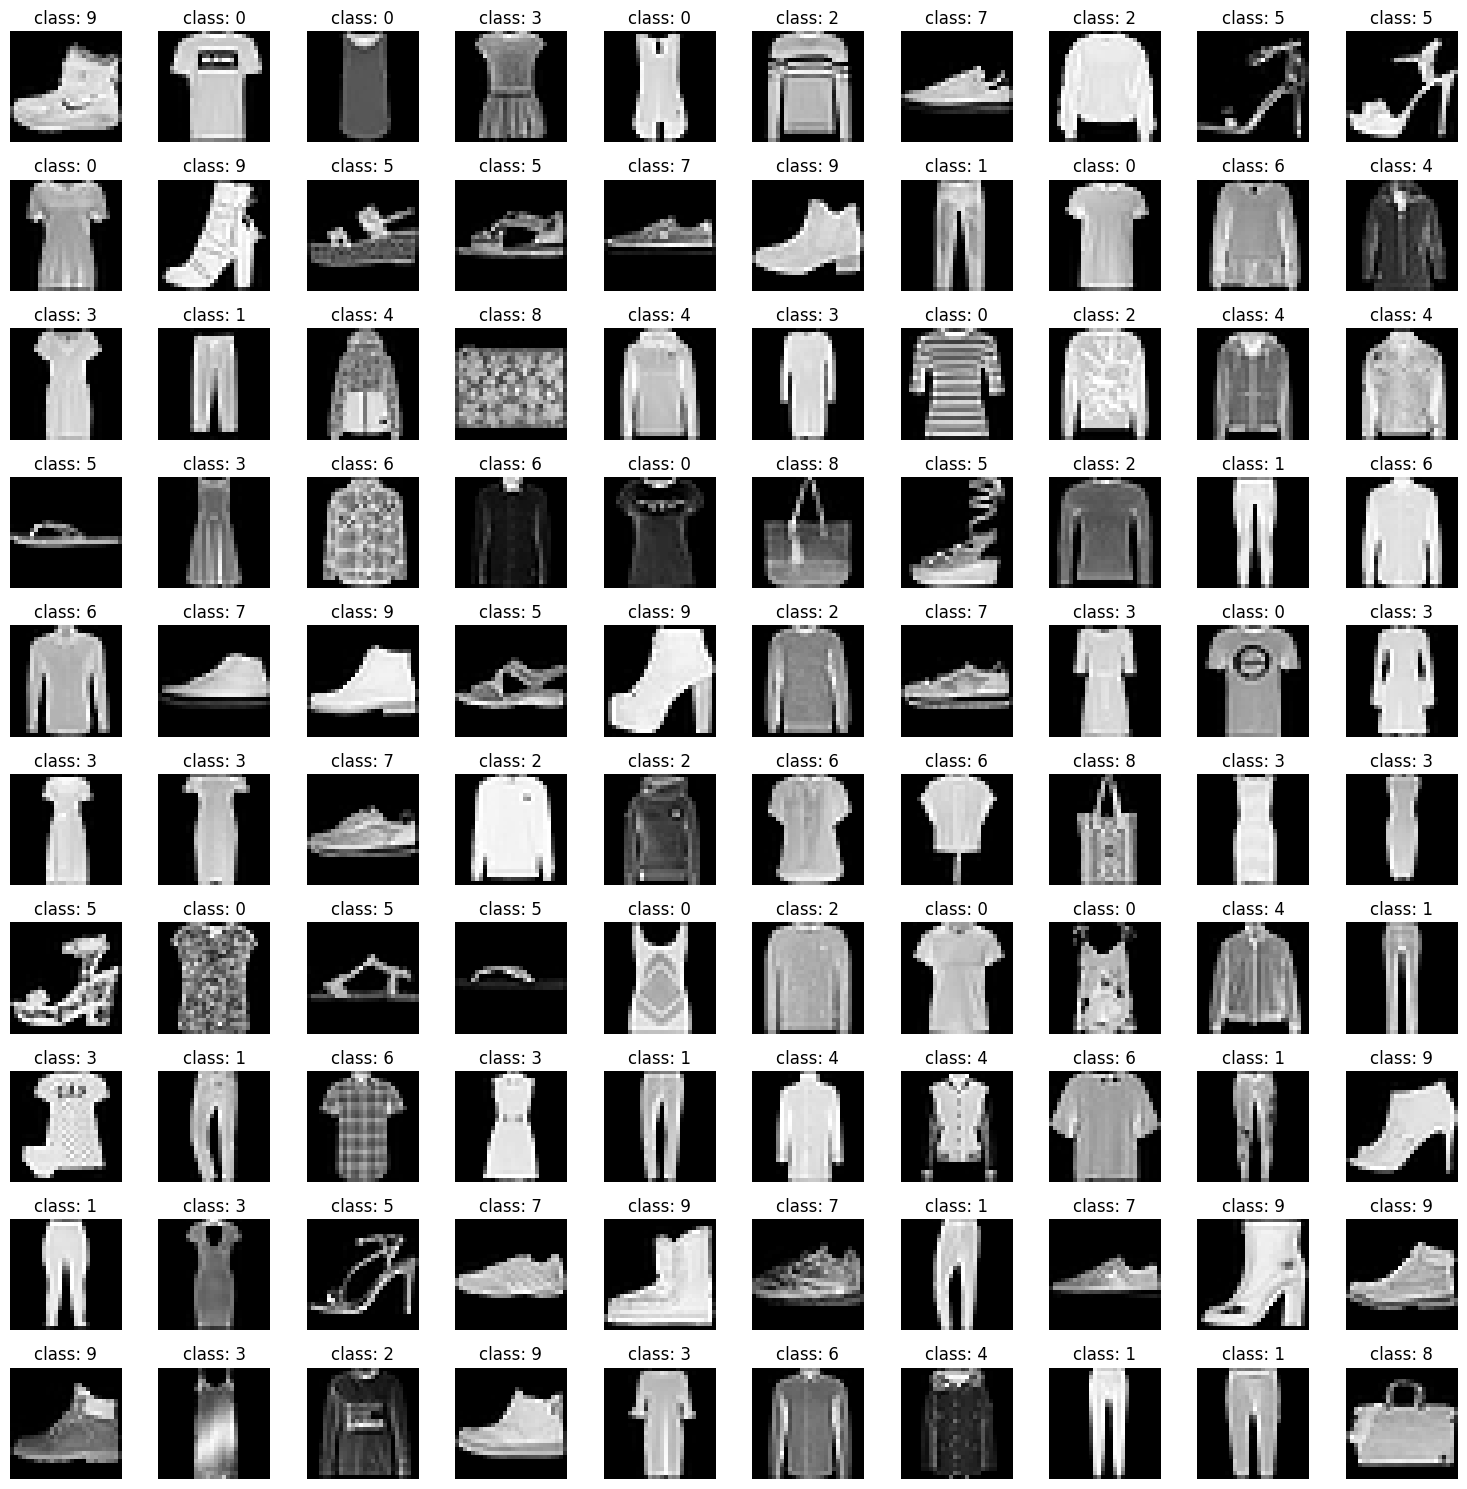

In [18]:
plt.figure(figsize=(15,15))
for ii in range(100):
    image = train_img[ii]
    label = train_labels[ii]
    plt.subplot(10,10,ii+1)
    plt.imshow(image.reshape((28,28)), cmap='gray')
    plt.title(f"class: {label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Question:** Is the train set **balanced**?
    
</div>

In [19]:
# Is it balanced? Count the number of elements per class.
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

*TODO* answer YES

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Question:** Is the train set **sorted**?
    
</div>

In [21]:
# Is it sorted (quick check)?
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

*TODO* answer NO

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Question:** Does the train set look noisy (at first sight)?
    
*Hint:* Display the first images for each class.
    
</div>

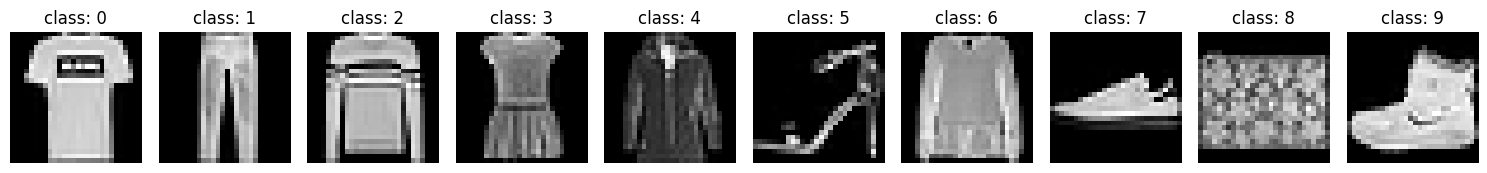

In [38]:
# TODO code

def tab_per_class(input_tab, class_nbre, nbr_to_see):
    return np.where(input_tab == class_nbre)[0][:nbr_to_see]


plt.figure(figsize=(15,15))
for ii in range(10):
    label = tab_per_class(train_labels, ii, 1)
    image = train_img[label[0]]
    
    plt.subplot(10,10,ii+1)
    plt.imshow(image.reshape((28,28)), cmap='gray')
    plt.title(f"class: {ii}")
    plt.axis("off")
plt.tight_layout()
plt.show()



*TODO answer* Yes

## 1. Train a tee-shirt/top vs pull-over classifer (class 0 vs class 2)
In the first exercise we will leverage scikit-learn's great classifiers to quickly get a baseline.

To avoid premature complexity, we will first focus on the case of a binary classifier, i.e. a case where data can only be classified into two classes. We usually label those classes `0` and `1`.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Train a classifier to discriminate images from class 0 ("tee-shirt/top") and class 2 ("pull-over").

*Hints:*
- Use the `select_2_classes()` function below to generate a train and a test set.
- Use a `LinearSVC` classifier with default parameters (but custom seeding for reproducibility), unless you have some particular classifier you want to try. Note that most of the questions assume you will use the `LinearSVC` classifier.
    
</div>

In [39]:
def select_2_classes(X, y, label_a, label_b):
    """
    Transforms our dataset to select only samples and labels which have either `label_a` or `label_b`.
    
    Parameters
    ----------
    
    X: np.array of shape: (n_samples, n_features)
        Array of samples
    
    y: np.array of shape: (n_samples, ); dtype: np.uint8
        Array of labels for each sample (integer format)
    
    label_a: integer
        Value of the first label to keep
    
    label_b: integer
        Value of the other label to keep
    
    Returns
    -------
    new_X, new_y: same type and shape as `X` and `y`
        Selection of samples and labels whose labels are either `label_a` or `label_b`.
    """
    selection_a_b = (y == label_a) | (y == label_b)
    new_X = X[selection_a_b]
    new_y = y[selection_a_b]
    new_y = (new_y == label_a).astype(y.dtype)  # could be removed for most of this lab
    return new_X, new_y

In [40]:
# Creation of the train set
x_train, y_train = select_2_classes(train_img, train_labels, 0, 2)
x_train.shape, x_train.dtype, y_train.shape, y_train.dtype

((12000, 784), dtype('uint8'), (12000,), dtype('uint8'))

In [41]:
# TODO create the test set the same way
x_test, y_test = select_2_classes(test_img, test_labels, 0, 2)
x_test.shape, y_test.shape

((2000, 784), (2000,))

Create the classifier

In [43]:
# TODO create the classifier here and train it
from sklearn.svm import LinearSVC

model =  LinearSVC()

model.fit(x_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

## 2. Evaluation

### 2.1. Qualitative evaluation / visual inspection
Now that your classifier is trained, you should first check the results visually for a qualitative control.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using the `plot_some_results` and `plot_some_errors` functions provided below, display some predictions from the test set and control that they make sense.**

</div>

In [44]:
def plot_some_results(x_data, y_true, y_pred, /, num_elements=100):
    """
    Plot the `num_elements` first results in a fancy way.
    
    Parameters
    ----------
    x_data: np.array of shape: (n_observations, n_features), dtype: np.uint8
        Image data
    
    y_true: np.array of shape: (n_observations, ), dtype: np.uint8
        Expected (true) labels.
        
    y_pred: np.array of shape: (n_observations, ), dtype: np.uint8
        Predicted labels.
        
    num_elements: int, default=100
        Number of elements to plot.
    
    Returns
    -------
    None
    """
    num_cols = 10
    num_rows = (num_elements + num_cols - 1) // num_cols
    plt.figure(figsize=(15,15))
    for ii in range(min(x_data.shape[0], num_elements)):
        image = x_data[ii]
        label_true = y_true[ii]
        label_pred = y_pred[ii]
        plt.subplot(num_rows,num_cols,ii+1)
        plt.imshow(image.reshape((28,28)), cmap='gray')
        if label_pred == label_true:
            plt.title(f"OK: {label_true}")
            frame_color = 'g'
        else:
            plt.title(f"ERR: E{label_true} -> P{label_pred}")
            frame_color = 'r'
        h, w = 28, 28
        plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [45]:
def plot_some_errors(x_data, y_true, y_pred, /, num_elements=100):
    """
    Plot the `num_elements` first errors in a fancy way.
    
    Parameters
    ----------
    x_data: np.array of shape: (n_observations, n_features), dtype: np.uint8
        Image data
    
    y_true: np.array of shape: (n_observations, ), dtype: np.uint8
        Expected (true) labels.
        
    y_pred: np.array of shape: (n_observations, ), dtype: np.uint8
        Predicted labels.
        
    num_elements: int, default=100
        Number of elements to plot.
    
    Returns
    -------
    None
    """
    selection_errors = y_pred != y_true
    plot_some_results(x_data[selection_errors], y_true[selection_errors], y_pred[selection_errors])

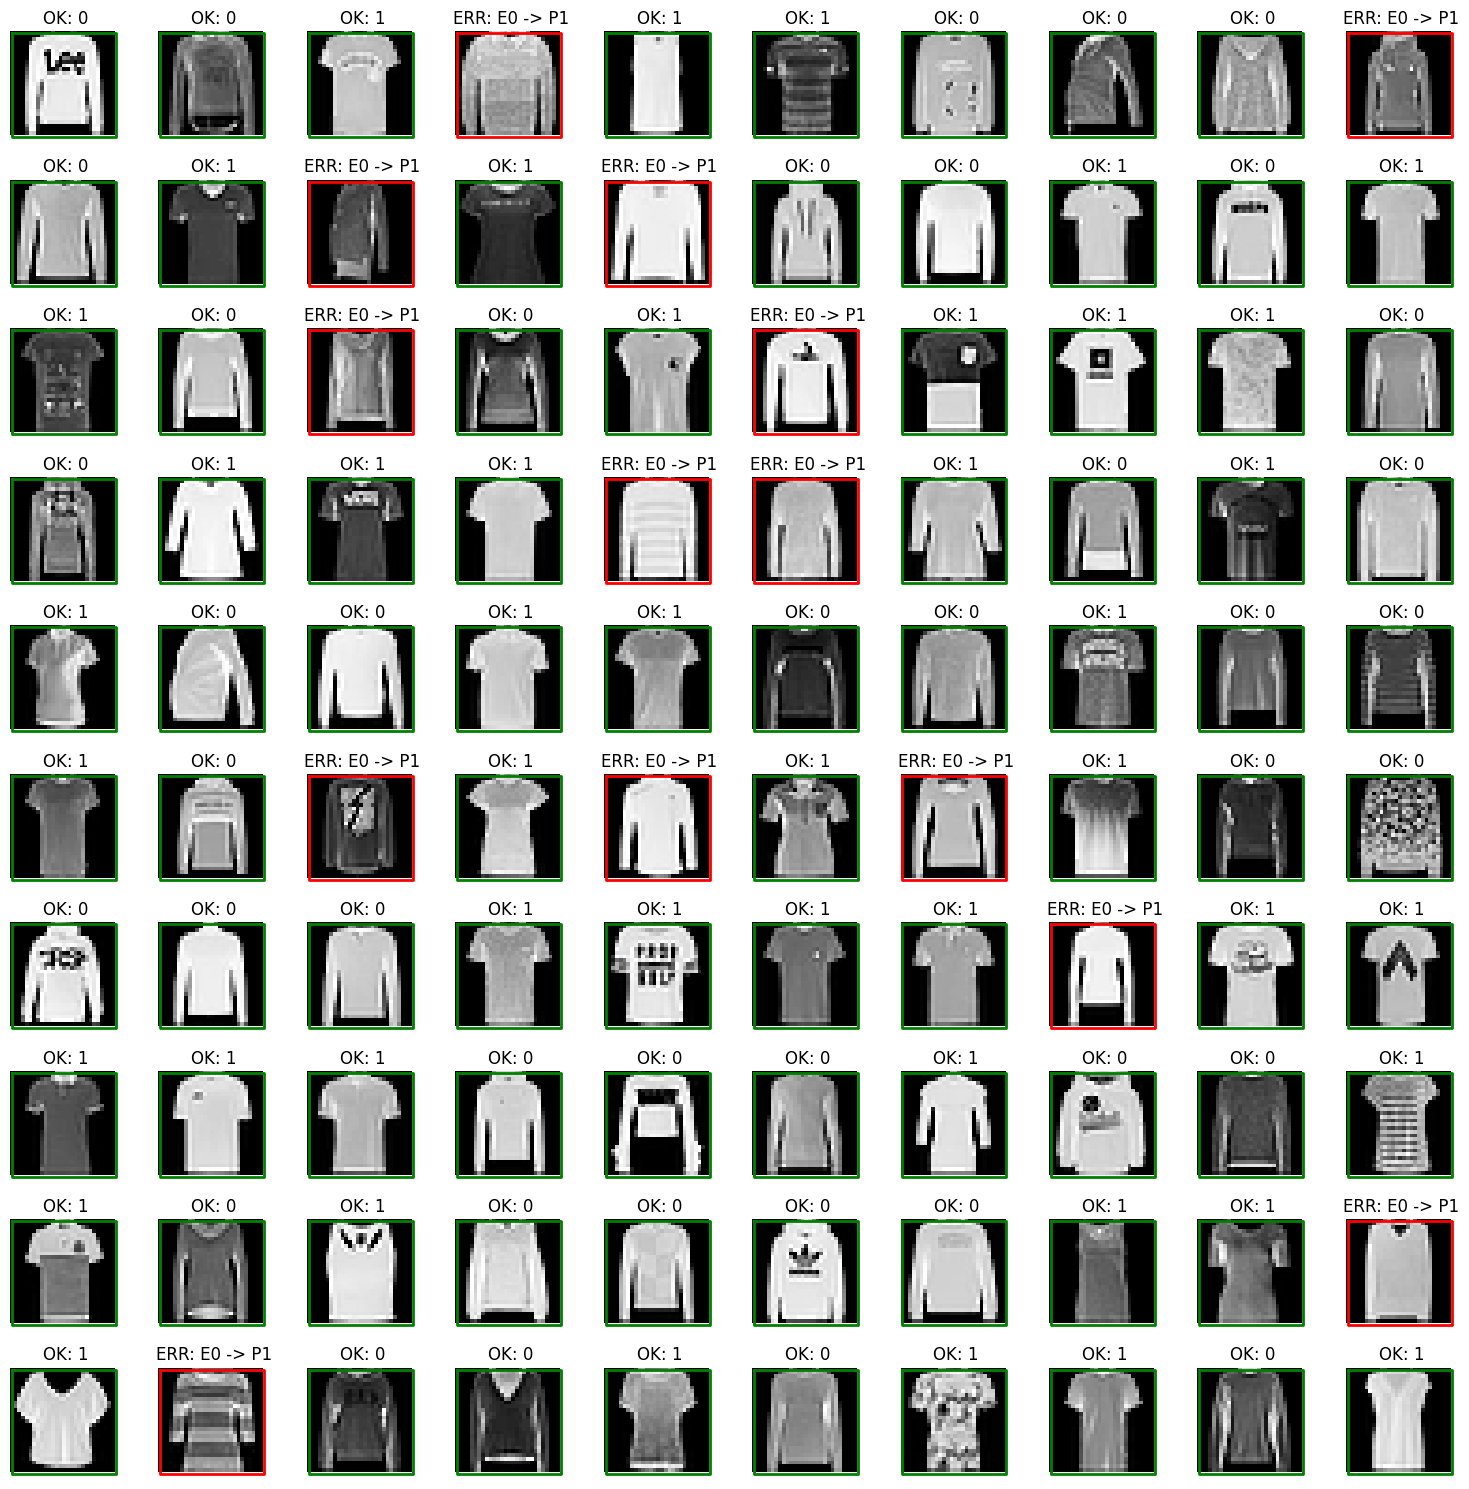

In [46]:
# TODO 
y_pred = model.predict(x_test)
plot_some_results(x_test, y_test, y_pred)

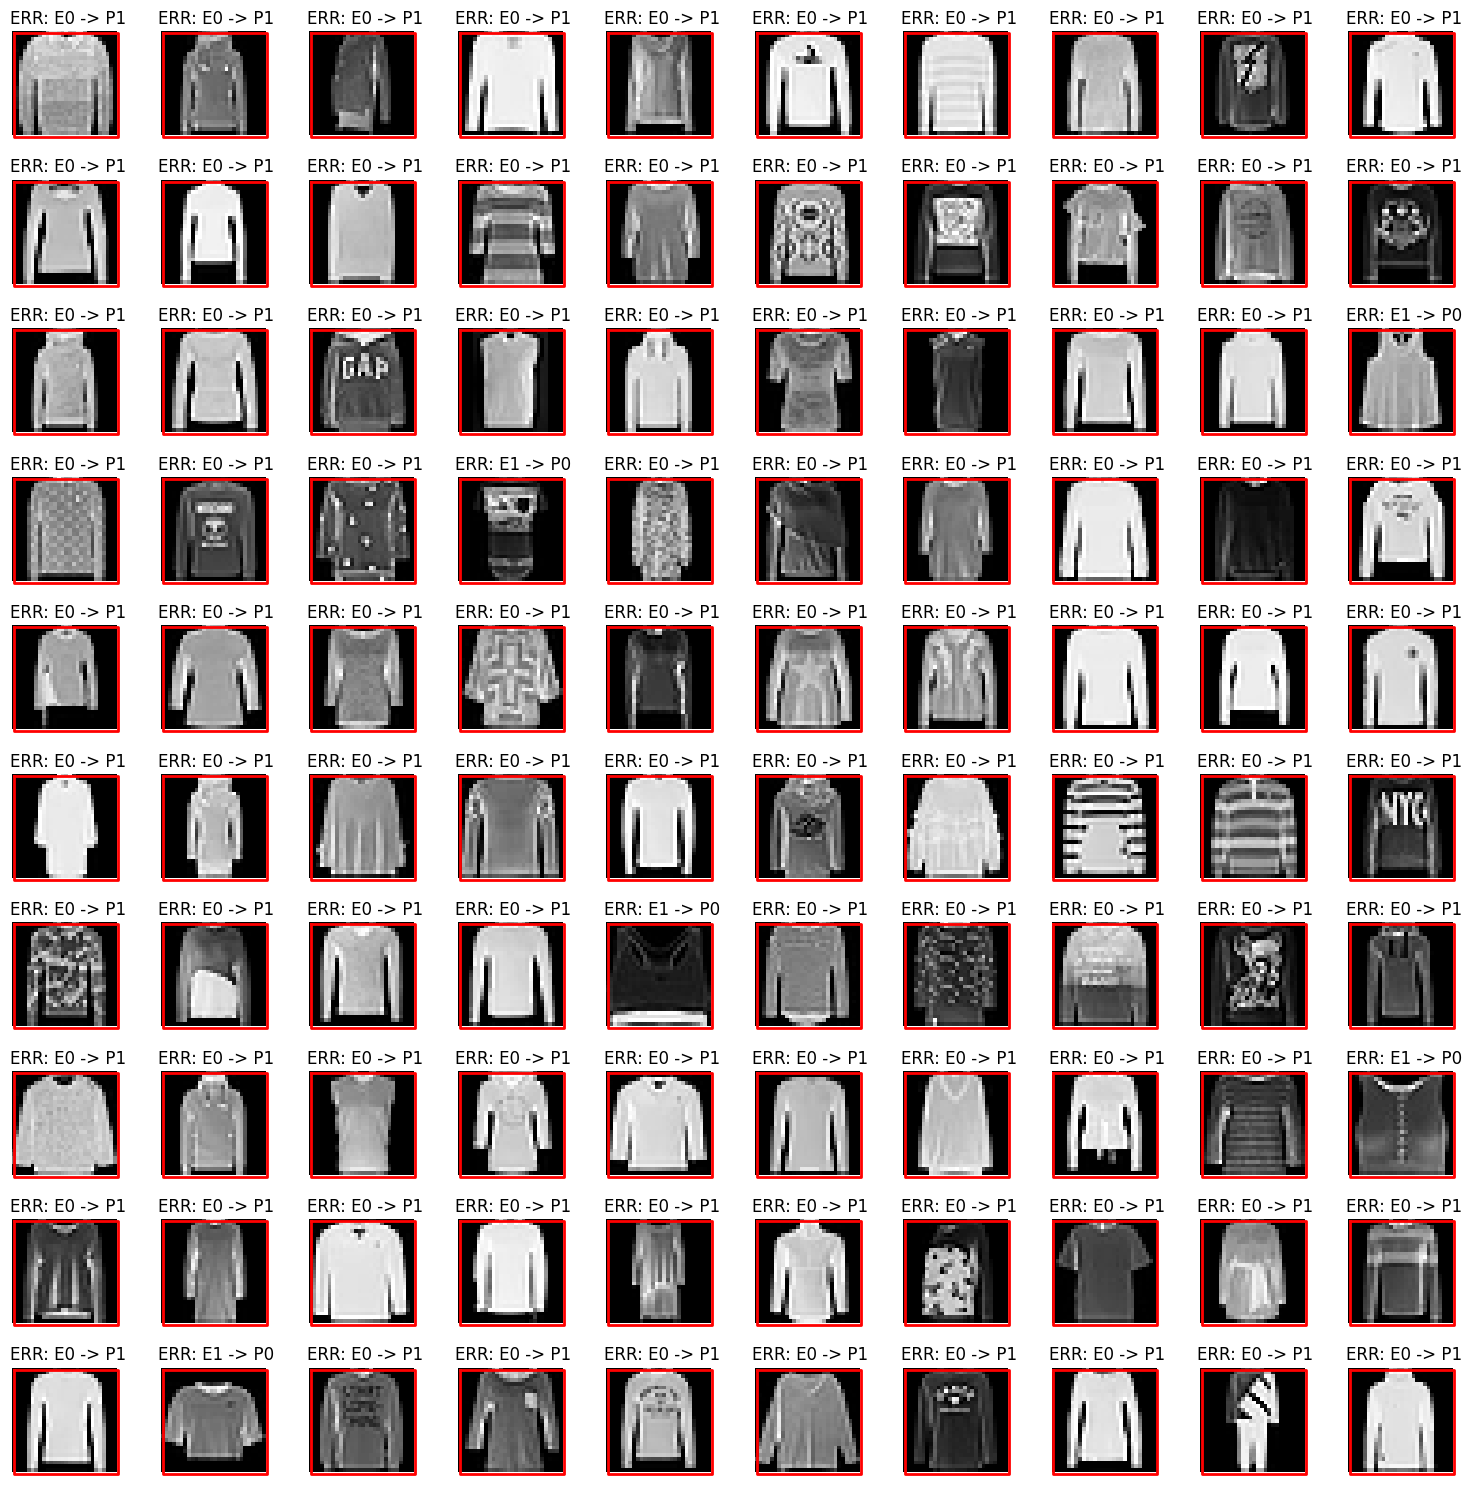

In [47]:
# TODO 

plot_some_errors(x_test, y_test, y_pred)

Do the errors make sense?

Can you say for sure whether it is a tee-shirt/top or a pull-over in each case?

In [49]:
# You can save your classifier for future use if you want to.
# For more details, see:
# https://scikit-learn.org/stable/modules/model_persistence.html#model-persistence

from joblib import dump, load
dump(model, 'tmp_clf/clf_type_param_moreinfo.joblib')

['tmp_clf/clf_type_param_moreinfo.joblib']

### 2.2. Accuracy
We are now going to evaluate the performance of the classifier using the integrated `score` method.

In [51]:
model.score(x_test, y_test)

0.883

The `score` method reports the accuracy:


\begin{equation}
\large
\mathrm{Accuracy} = \frac{\text{Correct predictions}}{\text{All predictions}}
\end{equation}
    
*In the next section we will provide a more precise definition.*

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Implement the function `my_accuracy` below to get the same result.

</div>

In [67]:
def my_accuracy(y_true, y_pred):
    """
    Computes the accuracy of some classification results.
    
    Parameters
    ----------
    y_true: np.ndarray of shape (n_samples, )
        True expected labels.
    
    y_pred: np.ndarray of shape (n_samples, )
        Predicted labels.
    
    Returns
    -------
    accuracy: float
        Accuracy of the classification results, i.e. the number of correctly classified elements (correct label)
        divided by the total number of predictions.
    
    """
    diff = y_true == y_pred
    acc = len(diff == True) / len(y_true)
    return acc

2000
2000


We should get the same result as before here:

In [64]:
my_accuracy(y_test, model.predict(x_test))

0


1.0

### 2.3. Confusion Matrix
The accuracy is a very basic indicator which weights all errors equally.
However, the cost of misclassification from A to B is not always the same as the cost of recognizing A instead of B (think of a fraud detection system for example).

The confusion matrix is the key to understand the core indicators: accuracy, precision, recall, etc.

For a binary classifier, labels are either `1` (`True`) or `0`(`False`), and the confusion matrix is composed of only 4 elements:
- true positives: elements for which the expected value is `True` and the predicted value is `True` as well;
- true negatives: elements for which the expected value is `False` and the predicted value is `False` as well;
- false negatives: elements which were expected to be `True` but were predicted as `False`;
- false positives: elements which were expected to be `False` but were predicted as `True`.

Let us look at the confusion matrix of your classifier…

In [ ]:
# You may need to adapt this line to match your variable names
sklearn.metrics.plot_confusion_matrix(clf, x_test, y_test) 

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

What are the counts of true positives, true negatives, false positives and false negatives produces by your classifier?

</div>

TODO answer

### 2.4. Precision, Recall, F-Score

Based on these terms, the accuracy has the following definition:

\begin{equation}
\large
\mathrm{Accuracy} = \frac{\mathrm{TP}+\mathrm{TN}}{\mathrm{TP}+\mathrm{TN}+\mathrm{FP}+\mathrm{FN}}
\end{equation}

And [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) are:

\begin{equation}
\large
\mathrm{Precision} = \frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}
\end{equation}

\begin{equation}
\large
\mathrm{Recall} = \frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}
\end{equation}

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Compute the precision and recall of your previous classification results.
</div>

In [ ]:
def my_binary_precision(y_true, y_pred):
    """
    Computes the precision of some binary classification results.
    
    Parameters
    ----------
    y_true: np.ndarray of shape (n_samples, ) and dtype bool
        True expected labels.
    
    y_pred: np.ndarray of shape (n_samples, ) and dtype bool
        Predicted labels.
    
    Returns
    -------
    precision: float
        Precision of the binary classification results.
    
    """
    tp = ???
    fp = np.sum(~y_true & y_pred)
    return ???

In [ ]:
def my_binary_recall(y_true, y_pred):
    """
    Computes the recall of some binary classification results.
    
    Parameters
    ----------
    y_true: np.ndarray of shape (n_samples, ) and dtype bool
        True expected labels.
    
    y_pred: np.ndarray of shape (n_samples, ) and dtype bool
        Predicted labels.
    
    Returns
    -------
    recall: float
        Recall of the binary classification results.
    
    """
    tp = ???
    fn = ???
    return ???

In [ ]:
# TODO compute precision and accuracy for the predictions of our classifier on the test set
# ...

The [F-score](https://en.wikipedia.org/wiki/F-score), finally, is the [Harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean#Harmonic_mean_of_two_numbers) of precision and recall:


\begin{equation}
\large
F_1 = \frac{2}{\mathrm{recall^{-1}} + \mathrm{precision^{-1}}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}} = \frac{\mathrm{TP}}{\mathrm{TP} + \frac12 (\mathrm{FP} + \mathrm{FN}) }
\end{equation}

### 2.5. PR and ROC curves
For most classifiers, it is possible to rank their prediction on the test set by probability, confidence, or some other form of score.

With scikit-learn, classifiers which can provide such information implement either:
- a `predict_proba()` method which assigns a `True` probability for each sample;
- or a `decision_function()` method which predicts confidence scores for samples.


In the case of `LinearSVN`, the [`decision_function()`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function) returns the confidence score associated to each sample.
The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane.

Using either of these methods, is is possible to plot, for each possible threshold, the numbers of TP, FP, FN, TN… or any other indicator derived from them.

### Some intuition

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Here is (below) the distribution of confidence score produced by the decision function (assuming you used a LinearSVC) **for the train set**.

**Where are the majority of the values?**
</div>

In [ ]:
confidence_scores = clf.decision_function(x_train)
confidence_scores.shape, confidence_scores.dtype

In [ ]:
plt.hist(confidence_scores, bins=100)
plt.title("Distribution of confidence scores")

TODO some thoughts about this distribution…

What is more interesting is to plot the distribution of such values according to the class the samples belong to.

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(confidence_scores[y_train==0], bins=50, color='b', label="Class 0", alpha=0.6)
plt.hist(confidence_scores[y_train==1], bins=50, color='g', label="Class 1", alpha=0.6)
plt.legend()
plt.title("Distribution of confidence scores for each class")

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Based on the previous plot, assuming each error (FP and FN) have the same cost, what is roughly the optimal decision threshold (on the x-axis) which will minimize the total error?
</div>

TODO answer

### Precision and Recall

`sklearn.metrics.precision_recall_curve` provides a very nice way to compute all the values that precision and recall would take by selecting each of the possible thresholds.

Here we will look at the values from the training set (because we will try to calibrate the decision function in the next section).

In [ ]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_train, clf.decision_function(x_train))

We provide you with some extra visualization function which can help.

In [ ]:
def plot_precision_recall_vs_threshold_vs_f1(precisions, recalls, thresholds):
    f1 = 2 * precisions * recalls / (precisions + recalls)
    plt.plot(thresholds, f1[:-1], 'r:', label="$F_1$ score")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    amax_f1 = np.argmax(f1)
    thr_best_f1 = thresholds[amax_f1]
    plt.plot([thr_best_f1, thr_best_f1], [0, f1[amax_f1]], "k:", linewidth=2)
    plt.xlabel(f"Thresholds (best for $F_1$ @ $T$ = {thr_best_f1:0.2f}: " 
               f"$F_1$ = {f1[amax_f1]:0.2f}; $P$ = {precision[amax_f1]:0.2f}; $R$ = {recall[amax_f1]:0.2f})",
               fontsize=14);
    plt.legend(fontsize=14)  # loc="upper left", fontsize=16
    plt.grid()
    plt.ylim([0, 1])
    plt.xlim([np.min(thresholds), np.max(thresholds)])

In [ ]:
plt.figure(figsize=(16, 8))
plot_precision_recall_vs_threshold_vs_f1(precision, recall, thresholds)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

By default, the `predict()` method will assume that values which are $\geq 0$ are `True` and values $\lt 0$ are `False`.

**Is $0$ the best possible threshold here to maximize the accuracy? To maximize $F_1$?**
</div>

TODO what about the calibration?

Before looking a the calibration of the predictor in more detail, let us discover the PR and ROC curves.

### Precision vs Recall curve
Using precision and recall values computed for each threshold, it is possible to plot precision(t) vs recall(t) for each t (threshold).

This gives an idea of the different operation modes our system could have based on the threshold we choose: 
- either very precise (no noise, high precision) but at the cost of few relevent elements detected (low recall);
- very sensitive (high recall, lot of elements) at the cost of more noise in the results (low precision);
- or anything in between depending on the requirements of the problem!

In [ ]:
sklearn.metrics.plot_precision_recall_curve(clf, x_test, y_test)

### Receiver Operating Characteristic (ROC) curve

The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), finally, plots the true positive rate (aka sensitivity, **recall**, hit rate) vs the false positive rate (aka fall out, 1 minus specificity, etc.)

\begin{equation}
\large
\mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}=1-\mathrm {FNR} = \text{Recall}
\end{equation}

\begin{equation}
\large
\mathrm {FPR} ={\frac {\mathrm {FP} }{\mathrm {N} }}={\frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TN} }}=1-\mathrm {TNR}
\end{equation}

It illustrates a kind of signal vs noise compromise: what is the amount of false positive (e.g. background noise) you will have to face to increase the recall (e.g. voice signal over radio transmitter).

In [ ]:
sklearn.metrics.plot_roc_curve(clf, x_test, y_test)

## 3. Calibration

Calibration should be done on validation set but we can illustrate the process here on the train set directly.
As long as we do not calibrate on the test set, this cannot be very wrong…

Calibration (here) is about how to find the threshold which maximizes some metric.

Let us first compute the uncalibrated predictions, and compute their accuracy **on the test set**.

In [ ]:
uncalibrated_predictions = clf.predict(x_test)
uncalibrated_predictions[:10]

In [ ]:
my_accuracy(y_test, uncalibrated_predictions)

In [ ]:
sklearn.metrics.confusion_matrix(y_test, uncalibrated_predictions)

Now, let us compute a new threshold **on the train set** which will **maximize the accuracy**, and evaluate the quality of the new decision **on the test set**.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Complete the code of the function `find_best_threshold_for_accuracy` below to compute the new decision with a new threshold, and analyse the results on the test set.
</div>

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def find_best_threshold_for_accuracy(y_true, uncalibrated_predictions):
    """
    Find the best threshold which maximizes accuracy for a given set of predictions.
    
    Parameters
    ----------
    y_true: np.array of shape (n_samples, )
        Expected predictions.
    
    uncalibrated_predictions: np.array of shape (n_samples, ) and dtype np.float
        Scores or probabilities assigned to each sample.
    
    Returns
    -------
    best_thresh, best_acc: float, float
        Best threshold and best accuracy obtained.
    """
    thresholds = uncalibrated_predictions
    best_acc = 0.
    best_thresh = None
    for t in thresholds:
        pred_t = ?????   # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< FIXME
        acc_t = accuracy_score(y_true, pred_t)
        if best_thresh is None or best_acc < acc_t:
            best_acc = acc_t
            best_thresh = t
    return best_thresh, best_acc

In [ ]:
best_thresh, best_acc = find_best_threshold_for_accuracy(y_train, clf.decision_function(x_train))
best_thresh, best_acc

In [ ]:
# Compute the new decisions on test set using the best threshold
calibrated_predictions = clf.decision_function(x_test) > best_thresh
calibrated_predictions[:10]

In [ ]:
my_accuracy(y_test, calibrated_predictions)

In [ ]:
sklearn.metrics.confusion_matrix(y_test, calibrated_predictions)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Is the accuracy on the test set better?
</div>

TODO
Answer

But we may be doing things the wrong way: we know our features are not normalized!

Let us try some…

## 4. Preprocessing
and learn how to use pipelines.

[Pipelines](https://scikit-learn.org/stable/modules/compose.html) are an elegant way to combine preprocessors (which have `fit()` and `transform()` methods) with predictors (wich have `fit()` and `predict()` methods) into a general object.

We encourage you to use this integrated way of combining pre-processing and classification because it prevents from forgetting to apply the same pre-processing to test data; a very common mistake!

To create pipelines, we can either use the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) constructor, or the factory function [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline).
Their signature is slightly different.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Create a pipeline which combines a `StandarScaler` with the same `LinearSVC` as we used before;
the train it on our binary case and evaluate its performance on our test set.

</div>

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

In [ ]:
pipeline = make_pipeline(????)  # FIXME

In [ ]:
%%time
pipeline.fit(x_train, y_train)

In [ ]:
pipeline.score(x_test, y_test)

In [ ]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_train, pipeline.decision_function(x_train))
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold_vs_f1(precision, recall, thresholds)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**How does the performance compares the our previous version?**
    
**Is the new predictor calibrated differently?**

</div>

TODO Answer

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

What are the step run by sklearn **during the training** in terms of calls to `fit()`, `transform()` and `predict()` for the preprocessor and for the classifier?

What are the step run by sklearn **during the testing/prediction** in terms of calls to `fit()`, `transform()` and `predict()` for the preprocessor and for the classifier?

</div>

TODO answer

## 5. Cross validation for better model selection
Here we want to get the best possible model without looking at the test set.

We will split the train set into several parts, training on all but one part and evaluating on the left one, then repeating the operation with another part left out.

We will keep the best performing model trained with this process.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Using [`sklearn.model_selection.StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) to separate the train set into train and **validation** subsets automatically, train several models and keep the best one based on its accuracy **on the validation set**.

Finally, evaluate the performance of the best model **on the test set**.

*Hint*: look at the example in the documentation of [`sklearn.model_selection.StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold).

</div>

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# TODO code

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Is our new model performing better?

What would be good usages of cross validation?

Do we really need a stratified splitter here?

*Some recommended readings:*
- API: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection
- Cross validation: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
- Hyper-parameter tuning: https://scikit-learn.org/stable/modules/grid_search.html#grid-search
- More about estimator's variance: https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

</div>

TODO answer

## 6. Optimize the meta-parameters using grid search
Let us now try to optimize the meta-parameters of our predictor.

We will continue to work on 2 classes for now because it may be slow on all classes.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Complete the code below to recreate the pipeline you used previously and set the grid parameters so you explore different values for the `C` parameter of our `LinearSVC`.

</div>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
# Create the pipeline object
pipeline = Pipeline([
    ("scaler", ???),  # <<<<<<< FIXME
    ("linearsvc", ???)  # <<<<<<< FIXME
])

# Create new parameter dictionary
grid_params = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'linearsvc__random_state': (0, 3),  # <<<<<<< REPLACEME
}

# Instantiate new gridsearch object
gs = GridSearchCV(pipeline, grid_params, n_jobs=6, verbose=4)

# Fit model to our training data
gs.fit(x_train, y_train)

# Score the model on our testing data
gs.score(x_test, y_test)

Pretty printing of the parameters

In [ ]:
import pandas as pd
df = pd.DataFrame(gs.cv_results_)
df

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Did we end up using a value for `C` different from the default one?

</div>

TODO
Answer

## 7. Multiclass version: all classes
In the section, we will train a multi-class classifier, and we will have a quick look at the multi-class classification strategies: OvO (one versus one) and OvR (one versus rest, aka one versus all).





<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

How many classifiers do we need to train for the 10 classes for our dataset with:
- OvO strategy?
- OvA strategy?

</div>

TODO answer

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

Using a `SGDClassifier` (which will have less troubles with all this data), train a prediction system on the complete training set, and evaluate its performance on the test set. Do not forget to display some results and errors to make sure they make sense, and plot the confusion matrix.

Make sure your system's performance is way above the expected performance a random system would have!

</div>

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
# TODO code

## 8. More classifiers!
Now you can try various classifiers, with appropriate evaluation.
Some suggestions: k nearest neighbor, linear regression, SVM with non-linear kernel (RBF typically), random forest…

In [ ]:
# code code code!

## 9. Meta-optim again, full problem, several classifiers, strat kfold, multiple seeding…
Using cross-validation try to find the best performing classifier with the best parameters from scikit-learn to solve the full problem (all classes).

Be ready of a night of computation. Do not burn your laptop; use some desktop computer or server!

In [ ]:
# code code code!